In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

c:\Users\malon\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [4]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [5]:
def get_adversial_exemple(model, image, label, eps=0.25):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adv_ex = image + eps*signed_grad    
    adv_ex = tf.clip_by_value(adv_ex, 0, 1)
    return adv_ex

In [6]:
# Shallow softmax model

shallow_softmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_softmax.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_softmax.fit(ds_train, epochs=5)
shallow_softmax.evaluate(ds_test)

Epoch 1/5
469/469 [==============================] - 2s 1ms/step - loss: 0.6762 - accuracy: 0.8330
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.3623 - accuracy: 0.9024
Epoch 3/5
469/469 [==============================] - 1s 950us/step - loss: 0.3193 - accuracy: 0.9126
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.2997 - accuracy: 0.9172
Epoch 5/5
79/79 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.9225


[0.277015745639801, 0.9225000143051147]

In [7]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100),
  tfa.layers.Maxout(50),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=5)
shallow_maxout.evaluate(ds_test)

Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 0.3826 - accuracy: 0.8943
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1482 - accuracy: 0.9577
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1075 - accuracy: 0.9684
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0849 - accuracy: 0.9745
Epoch 5/5
79/79 [==============================] - 0s 994us/step - loss: 0.0872 - accuracy: 0.9732


[0.08724754303693771, 0.9732000231742859]

In [8]:
# convert tf.data.Dataset to numpy array
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

# avaluate shallow_softmax model on adversarial examples

x_test_adv = [get_adversial_exemple(shallow_softmax, x, y,eps=0.25).numpy()[0] for x,y in zip(x_test, y_test)]
x_test_adv = np.array(x_test_adv)

l,a =  shallow_softmax.evaluate(x_test_adv, y_test)
c = np.mean(np.max(shallow_softmax.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {a} with a mean confidence of {c}", )

# evaluate shallow_maxout model on adversarial examples

x_test_adv = [get_adversial_exemple(shallow_maxout, x, y,eps=0.25).numpy()[0] for x,y in zip(x_test, y_test)]
x_test_adv = np.array(x_test_adv)

l,a =  shallow_maxout.evaluate(x_test_adv, y_test)
c = np.mean(np.max(shallow_maxout.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {a} with a mean confidence of {c}", )

313/313 [==============================] - 0s 958us/step - loss: 15.1915 - accuracy: 0.0000e+00
Accuracy on adversarial examples: 0.0 with a mean confidence of 0.8872452974319458
313/313 [==============================] - 0s 1ms/step - loss: 24.9860 - accuracy: 0.0026
Accuracy on adversarial examples: 0.0026000000070780516 with a mean confidence of 0.9102675914764404


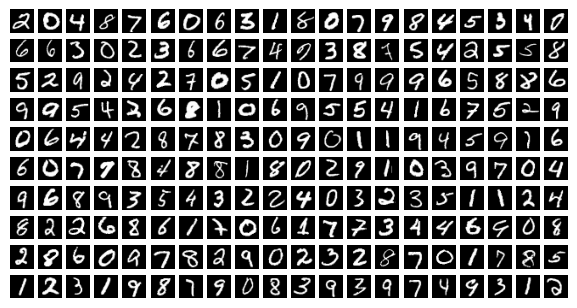

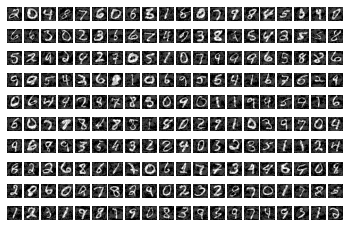

In [9]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(1)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.figure(2)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test_adv[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')

plt.show()

# Régression logistique pour classer 3 et 7
https://github.com/msotaquira/binary-logistic-regression-with-MNIST/blob/master/binary-logistic-regression-MNIST.py

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#flatten images
x_train = np.reshape( x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]) )
x_test = np.reshape( x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]) )

In [12]:
#keep only 3 and 7
X_train = np.vstack( (x_train[y_train==3], x_train[y_train==7]) )
Y_train = np.hstack( (y_train[y_train==3], y_train[y_train==7]) )
X_test = np.vstack( (x_test[y_test==3], x_test[y_test==7]) )
Y_test = np.hstack( (y_test[y_test==3], y_test[y_test==7]) )

In [13]:
# Shuffle training data and normalize both datasets
permute_indices = np.random.permutation(X_train.shape[0])
X_train = X_train[permute_indices,:]
Y_train = Y_train[permute_indices]

X_train = X_train/255.0
X_test = X_test/255.0

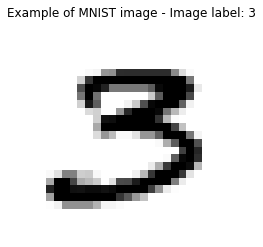

In [14]:
# Dìsplay an example train image
img_number = 18
plt.imshow(X_train[img_number,:].reshape(28,28), cmap="gray_r")
plt.title('Example of MNIST image - Image label: ' + str(Y_train[img_number]))
plt.axis('off')
plt.show()

In [15]:
# Binary (0,1) encoding of 'class_1' as 0 and 'class_2' as 1
Y_train[Y_train==3] = 0
Y_train[Y_train==7] = 1
Y_test[Y_test==3] = 0
Y_test[Y_test==7] = 1

c:\Users\malon\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
13/13 - 0s - loss: 0.5465 - accuracy: 0.7911
Epoch 2/30
13/13 - 0s - loss: 0.4343 - accuracy: 0.9075
Epoch 3/30
13/13 - 0s - loss: 0.3675 - accuracy: 0.9345
Epoch 4/30
13/13 - 0s - loss: 0.3221 - accuracy: 0.9459
Epoch 5/30
13/13 - 0s - loss: 0.2885 - accuracy: 0.9510
Epoch 6/30
13/13 - 0s - loss: 0.2631 - accuracy: 0.9551
Epoch 7/30
13/13 - 0s - loss: 0.2433 - accuracy: 0.9580
Epoch 8/30
13/13 - 0s - loss: 0.2273 - accuracy: 0.9606
Epoch 9/30
13/13 - 0s - loss: 0.2142 - accuracy: 0.9622
Epoch 10/30
13/13 - 0s - loss: 0.2032 - accuracy: 0.9633
Epoch 11/30
13/13 - 0s - loss: 0.1938 - accuracy: 0.9647
Epoch 12/30
13/13 - 0s - loss: 0.1857 - accuracy: 0.9649
Epoch 13/30
13/13 - 0s - loss: 0.1786 - accuracy: 0.9655
Epoch 14/30
13/13 - 0s - loss: 0.1724 - accuracy: 0.9660
Epoch 15/30
13/13 - 0s - loss: 0.1668 - accuracy: 0.9666
Epoch 16/30
13/13 - 0s - loss: 0.1619 - accuracy: 0.9668
Epoch 17/30
13/13 - 0s - loss: 0.1574 - accuracy: 0.9668
Epoch 18/30
13/13 - 0s - loss: 0.1534 - 

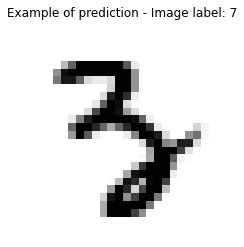

In [20]:
## Build the model

# - Input layer: 784 nodes (since each image has 28x28 = 784 pixels)
# - Output layer: 1 node with sigmoid activation (output labeled as '0' or '1')
# - No hidden layers

np.random.seed(1)		# fix random seed for reproducibility

input_dim = X_train.shape[1]
output_dim = 1 							

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(output_dim, input_dim = input_dim, activation='sigmoid'))

# Compile  and train the model
sgd = tf.keras.optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

num_epochs = 30
batch_size = 1024
history = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate and predict
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test accuracy:', score[1])

Y_pred = model.predict(X_test)

# Plot one example of prediction
img_number = 8
if Y_pred[img_number] == 0.0:
	predicted_class = 3
else:
	predicted_class = 7

plt.imshow(X_test[img_number,:].reshape(28,28), cmap="gray_r")
plt.title('Example of prediction - Image label: ' + str(predicted_class))
plt.axis('off')
plt.show()